In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import typing
import io
import os

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

from urllib.request import urlretrieve

from bovo.vit.utils.dataset import VitDataset
from PIL import Image
from torchvision import transforms

from bovo.vit.models.modeling import VisionTransformer, CONFIGS


In [11]:
os.makedirs("attention_data", exist_ok=True)
if not os.path.isfile("attention_data/ilsvrc2012_wordnet_lemmas.txt"):
    urlretrieve("https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt", "attention_data/ilsvrc2012_wordnet_lemmas.txt")
if not os.path.isfile("attention_data/ViT-B_16-224.npz"):
    urlretrieve("https://storage.googleapis.com/vit_models/imagenet21k+imagenet2012/ViT-B_16-224.npz", "attention_data/ViT-B_16-224.npz")

imagenet_labels = dict(enumerate(open('attention_data/ilsvrc2012_wordnet_lemmas.txt')))


In [12]:
# Test Image
# img_url = "https://images.mypetlife.co.kr/content/uploads/2019/04/09192811/welsh-corgi-1581119_960_720.jpg"
# urlretrieve(img_url, "attention_data/img.jpg")

# Prepare Model
config = CONFIGS["ViT-B_16"]
model = VisionTransformer(config, num_classes=1, zero_head=True, img_size=300, vis=True)
# model.load_from(np.load("results/models/vit0_checkpoint.bin"))
model.load_state_dict(torch.load("results/models/vit0_checkpoint.bin"))
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])


In [13]:
trainset = VitDataset(train=True, img_size=300, random=False)
print(trainset[0])
# x = transform(im)
x = trainset[0][0]
# x.size()

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]), 18)


In [14]:

def get_attn_mask (x):
    logits, att_mat = model(x.unsqueeze(0))

    att_mat = torch.stack(att_mat).squeeze(1)

    # Average the attention weights across all heads.
    att_mat = torch.mean(att_mat, dim=1)

    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    residual_att = torch.eye(att_mat.size(1))
    aug_att_mat = att_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

    # Recursively multiply the weight matrices
    joint_attentions = torch.zeros(aug_att_mat.size())
    joint_attentions[0] = aug_att_mat[0]

    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
        
    # Attention from the output token to the input space.
    v = joint_attentions[-1]
    grid_size = int(np.sqrt(aug_att_mat.size(-1)))
    mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
    mask = cv2.resize(mask / mask.max(), (300, 300), interpolation = cv2.INTER_CUBIC)[..., np.newaxis]
    return mask



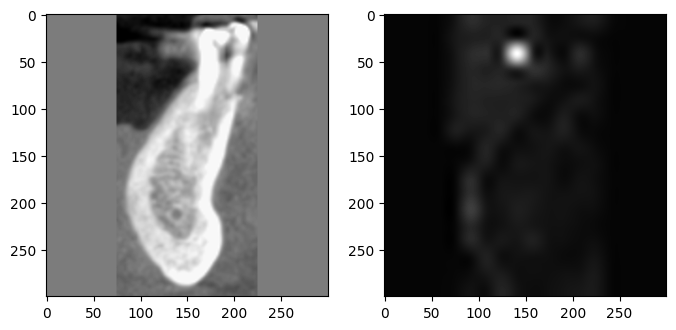

In [15]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 8))

x = trainset[0][0]
mask = get_attn_mask(x)
ax1.imshow(x[0], cmap="gray")
ax2.imshow(mask, cmap="gray")

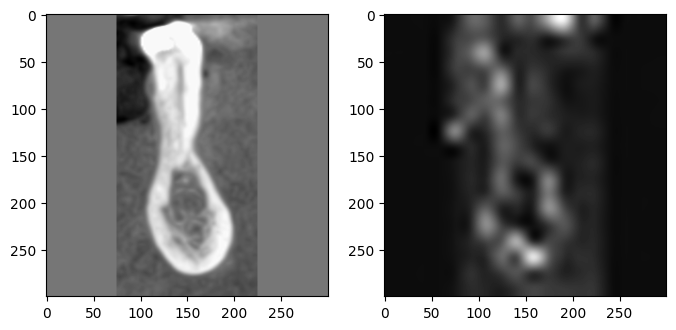

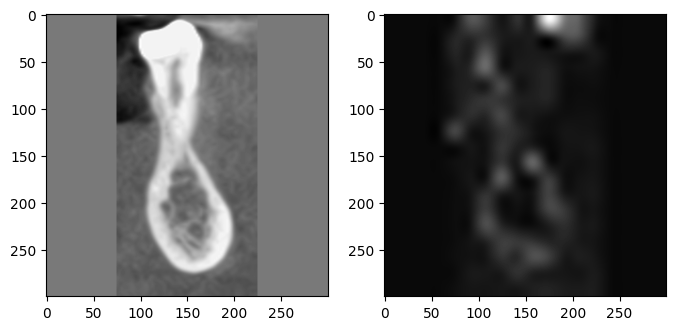

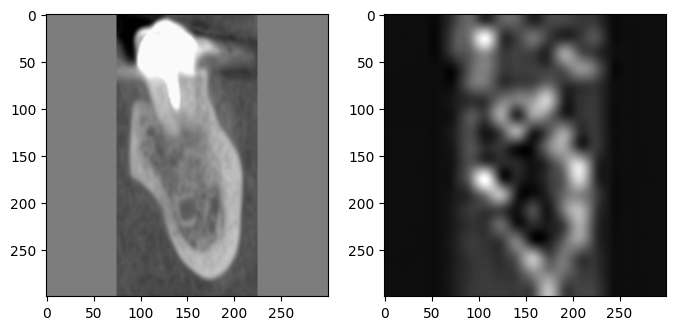

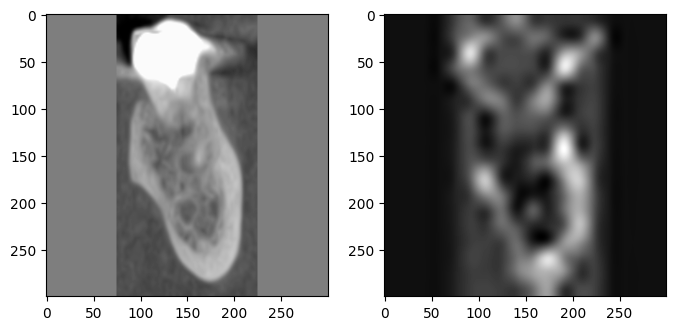

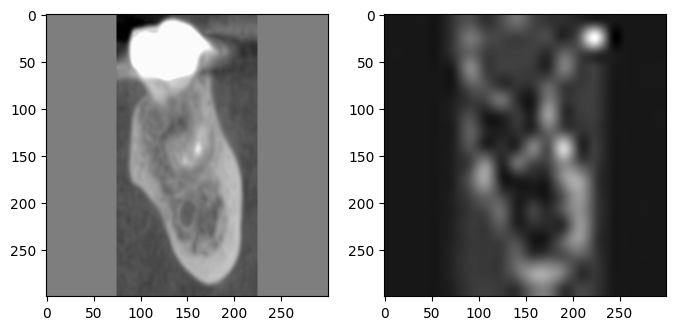

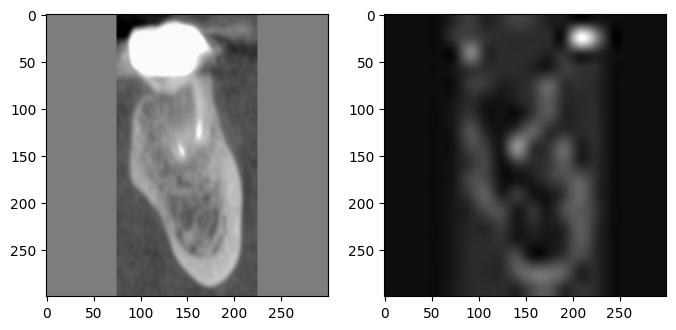

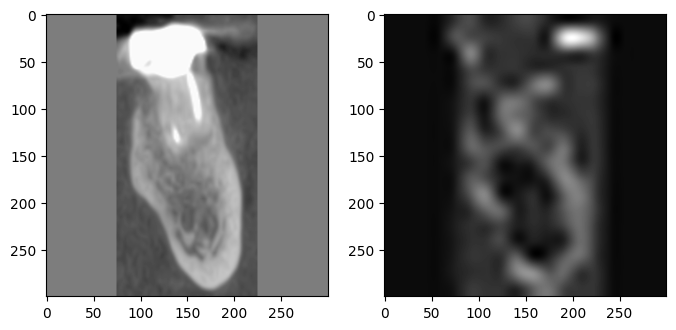

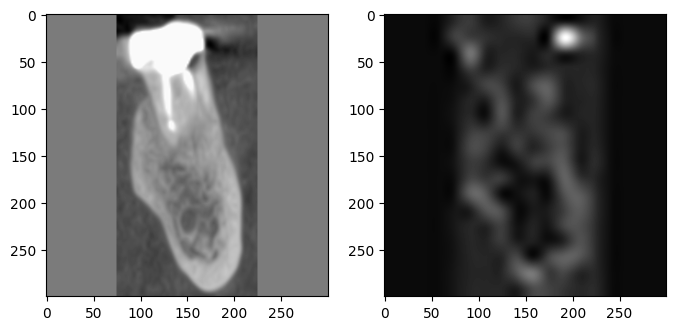

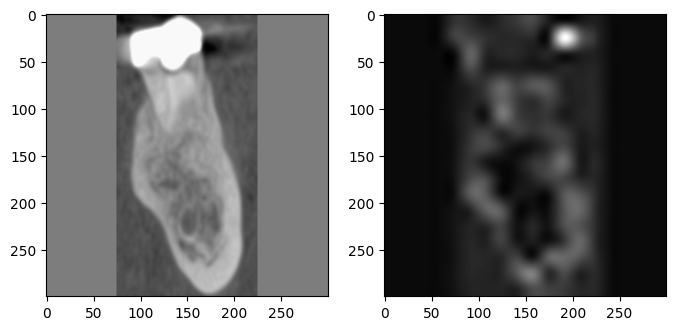

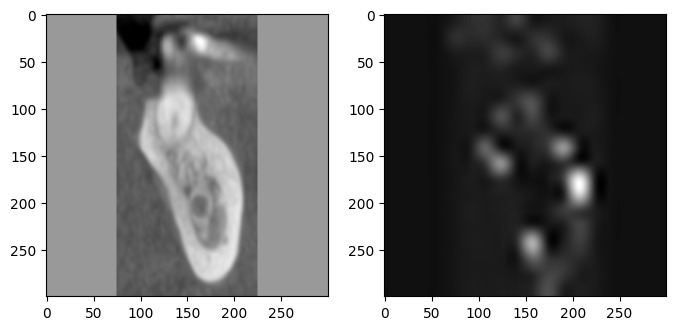

In [17]:

for i in range(10):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 8))

    x = trainset[i+100][0]
    mask = get_attn_mask(x)
    ax1.imshow(x[0], cmap="gray")
    ax2.imshow(mask, cmap="gray")
    plt.savefig("results/imgs/attention/{}.png".format(i))